# makemore: part 3

In [47]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [48]:
words=open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [49]:
len(words)

32033

In [50]:
#build the vocabulary of chars and to/from int
chars=sorted(list(set(''.join(words))))
#string to int 
stoi={s:i+1 for i,s in enumerate(chars)}
#special token to mark start and end of the word 
stoi['.']=0
#int to string 
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [51]:
#build the dataset 
block_size=3

def build_dataset(words):
    X,Y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)

n1=int(0.8*len(words))
n2=int(0.9*len(words))

#train(80%),dev(10%),test(10%)
Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

print('train :',Xtr.shape,Ytr.shape)
print('dev :',Xdev.shape,Ydev.shape)
print('test :',Xte.shape,Yte.shape)

train : torch.Size([182625, 3]) torch.Size([182625])
dev : torch.Size([22655, 3]) torch.Size([22655])
test : torch.Size([22866, 3]) torch.Size([22866])


In [52]:
n_embd=10 #dims of character embedding vectors  
n_hidden=200 #number of neurons in a hidden layer 

g=torch.Generator().manual_seed(2147483647) # for reproducibility 
C=torch.rand((vocab_size,n_embd),generator=g)

#kaiming-init 5/3 is the gain for tanh(constructive transformation)
#std=gain(5/3)/sqrt(fan_mode) || **0.5 ==sqrt(a)
W1=torch.rand((n_embd*block_size,n_hidden),generator=g) *(5/3)/((n_embd*block_size)**0.5)  

W2=torch.rand((n_hidden,vocab_size),generator=g) * 0.01
b2=torch.rand((vocab_size),generator=g) * 0

#batch norm parameters 
bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))

#since the w1 is init the mean at init will the around 0 and std 1   
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters=[C,W1,W2,b2,bngain,bnbias]
for p in parameters:
    p.requires_grad=True

In [53]:
max_steps=1
batch_size=32
lossi=[]

for i in range(max_steps):
    #construct mini batch 
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix] #sample out the batches 

    #forward pass 
    emb=C[Xb] # [32,3,10] shape each char has a 10d vector space 
    embcat=emb.view(emb.shape[0],-1) #contaenate the vectors ||[32,30]
    #linear layer 
    hpreact=embcat @ W1
    #Batch normalization layer     
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*(hpreact-bnmeani)/ bnstdi+bnbias

    #update without backpropagation for having at dev/test mean and std
    with torch.no_grad():
        bnmean_running=0.999 * bnmean_running + 0.001 *bngain
        bnstd_running=0.999 * bnstd_running + 0.001 *bngain

    #non linear layer || activ-func
    h=torch.tanh(hpreact)
    logits=h @ W2 + b2 # output lyaer
    loss= F.cross_entropy(logits,Yb) #softmax and loss function 

    #backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()

    #update  gradient descent 
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #track stats 
    if i% 10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())    



      0/      1: 3.2941


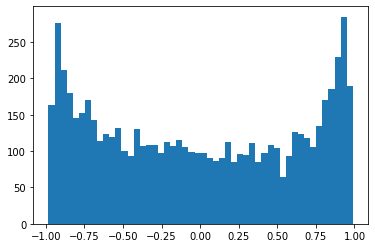

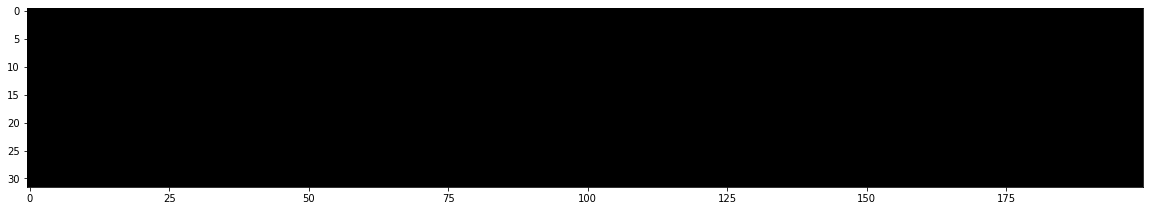

In [55]:
#visualize graphs 
#plot.plot(lossi)
plt.hist(h.view(-1).tolist(),50);


plt.figure(figsize=(20,10))
#white if the h.abs()>0.99(true) so the gradient would be destroyed
#check backward on tanh in micrograd      
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest');

In [56]:
# calibrate the batch norm at the end of training
#calcuate the mean and std over the entire training set  
#nobody wants to estimate this see code above || mean,std during training    
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [57]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.405348300933838
val 3.406759023666382


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [58]:
# SUMMARY + PYTORCHIFYING -----------

- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

the graph after 1000 epochs for activations and gradients are showing only the the final output layer the network did train but it looks like the parameters and gradients are not simetrical and values are probably way of not simetrical.



In [101]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        #normal distribution with kaiming initialization 
        #fan_in**0.5 == sqrt(a)
        self.weights=torch.randn((fan_in,fan_out),generator=g) /fan_in**0.5
        #self.weights=torch.zeros(fan_in,fan_out) #for ex1 testing
        self.bias=torch.zeros(fan_out)if bias else None

    def __call__(self,x):
        self.out=x @ self.weights
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    
    def parameters(self):
        return [self.weights]+([]if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        #parameters with backpropagation
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)


    def __call__(self,x):
        #calculate the forward pass 
        if self.training:
            xmean=x.mean(0,keepdim=True)
            xvar=x.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps) #normalize the var 
        #scale and shift
        self.out=self.gamma*xhat+self.beta
        #update the buffers for having mean and var during inference
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum+xvar
        return self.out

    def parameters(self):
        return [self.gamma,self.beta]


class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [102]:
n_embd=10 # dims of char embedding vectors  
n_hidden=100 #number of neurons in  a hidden layer
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size,n_embd),generator=g)

layers=[

    Linear(n_embd*block_size,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size,bias=False),BatchNorm1d(vocab_size),
]


with torch.no_grad():
    layers[-1].gamma*=0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weights*=0.1 # 5/3 kaiming initialization

#add C to to list in params 
parameters=[C] + [p for layer in layers for p in layer.parameters()]
#sum of params
print(sum(p.nelement() for p in parameters))

#parameters required grad for backpropagation 
for p in parameters:
    p.requires_grad=True

47024


In [105]:
max_steps=1000
batch_size=32
lossi=[]
ud=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]
    
    #forward pass 
    emb=C[Xb] # embed chars into vectors 
    x=emb.view(emb.shape[0],-1) #concatenate the vectors 
    for layer in layers:
        x=layer(x)
    #softmax and categorical cross entropy loss  
    loss=F.cross_entropy(x,Yb)


    #backward pass 
    for layer in layers:
        layer.out.retain_grad()#after debug comment out 

    for p in parameters:
        p.grad=None
    
    loss.backward()

    #update 
    lr = 0.1 if i<15000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


      0/   1000: 2.3966


c

layer 2 (      Tanh): mean -0.01, std 0.65, saturated: 2.94%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 1.47%
layer 8 (      Tanh): mean -0.01, std 0.67, saturated: 0.69%
layer 11 (      Tanh): mean -0.00, std 0.67, saturated: 0.38%
layer 14 (      Tanh): mean -0.01, std 0.67, saturated: 0.69%


Text(0.5, 1.0, 'activation distribution')

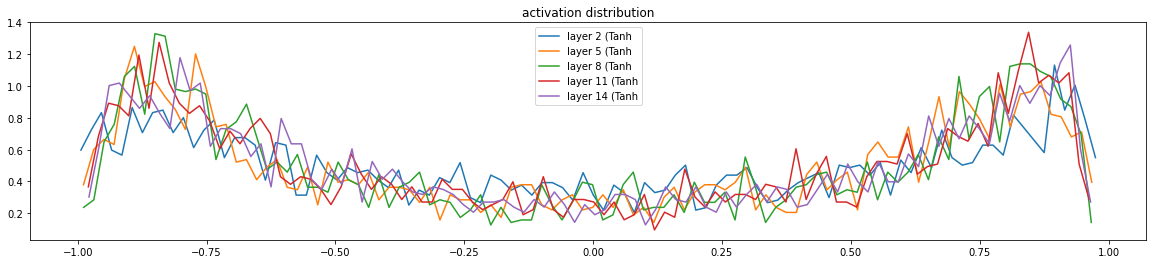

In [106]:
# visualize histograms with layer output   
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

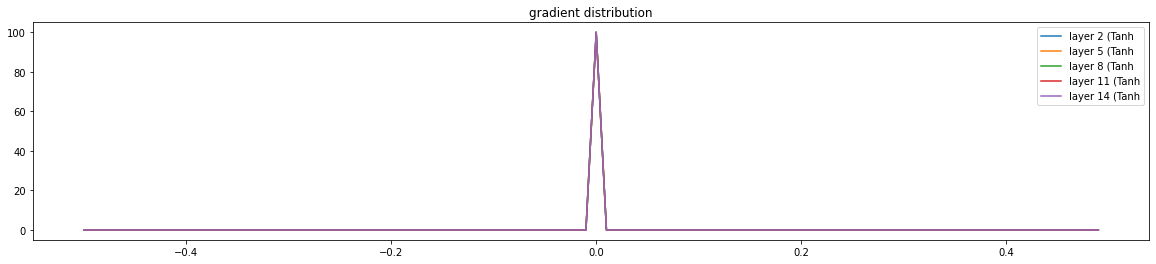

In [94]:
# visualize histograms with gradients 
#layers should have roughly the same gradients
#should be simetrical 
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


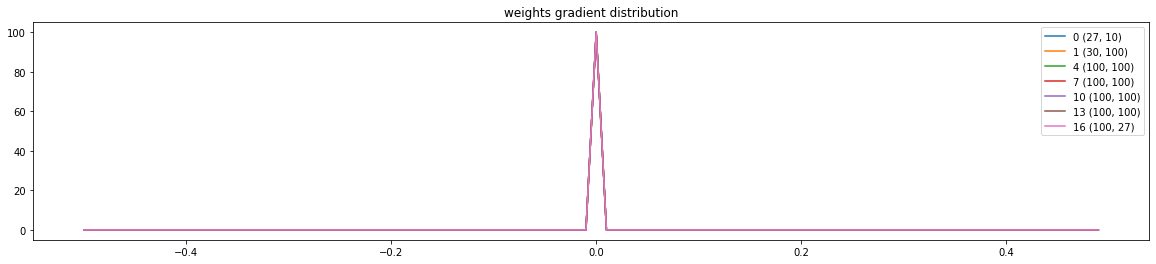

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

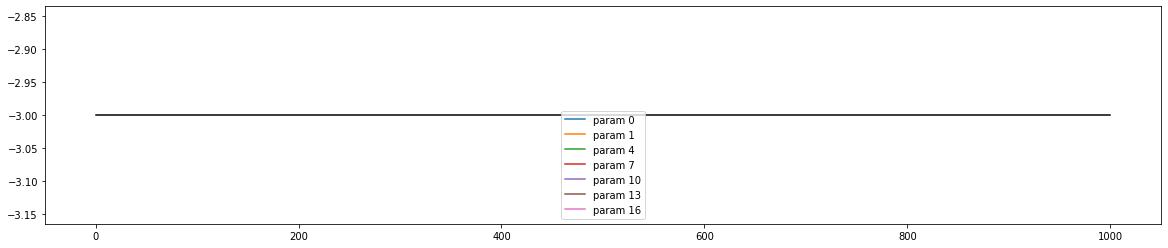

In [96]:
#plot update ratios
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [97]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.8336853981018066
val 2.8325846195220947


In [75]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

narpahxqae.
hlvihkimrlxreaty.
hnaassnejrzhnenfapesyhc.
iaqei.
nelmaiatceaiivdesleiyphhlm.
.
oin.
qeijnisrlilea.
vadbq.
wqaerogijaryxixfk.
eepiurai.
ed.
eaiia.
etlelhysrl.
aapae.
ovarhksyarimqqoaozeajlojn.
iaiaiereneep.
sadlnuo.
eoessr.
oiaahrynir.


- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [142]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True,training=True):
        #normal distribution with kaiming initialization 
        #fan_in**0.5 == sqrt(a)
        self.weights=torch.randn((fan_in,fan_out),generator=g) /fan_in**0.5
        #self.weights=torch.zeros(fan_in,fan_out) #for ex1 testing
        self.bias=torch.zeros(fan_out)if bias else None
        self.training=training


    def __call__(self,x):
        self.out=x @ self.weights
        if self.bias is not None:
            self.out+=self.bias
        
        if self.training is False:
            xhat=(self.out-self.running_mean)/torch.sqrt(self.running_var+self.eps) #normalize the var 
            self.out+=self.gamma*xhat+self.beta
        
        return self.out
    
    def batch_params(self,gamma,beta,running_mean,running_var,eps):
        self.gamma=gamma
        self.beta=beta
        self.running_mean=running_mean
        self.running_var=running_var
        self.eps=eps

    def parameters(self):
        return [self.weights]+([]if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        #parameters with backpropagation
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)


    def __call__(self,x):
        #calculate the forward pass 
        if self.training:
            xmean=x.mean(0,keepdim=True)
            xvar=x.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps) #normalize the var 
        self.out=self.gamma*xhat+self.beta
        #update the buffers for having mean and var during inference
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum+xvar
        return self.out

    def parameters(self):
        return [self.gamma,self.beta]


class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [143]:
n_embd=10 # dims of char embedding vectors  
n_hidden=100 #number of neurons in  a hidden layer
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size,n_embd),generator=g)

layers=[
    Linear(n_embd*block_size,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size,bias=False),
]

#add C to to list in params 
parameters=[C] + [p for layer in layers for p in layer.parameters()]
#sum of params
print(sum(p.nelement() for p in parameters))

#parameters required grad for backpropagation 
for p in parameters:
    p.requires_grad=True


6170


In [144]:
max_steps=100
batch_size=32
lossi=[]
ud=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]
    
    #forward pass 
    emb=C[Xb] # embed chars into vectors 
    x=emb.view(emb.shape[0],-1) #concatenate the vectors 
    for layer in layers:
        x=layer(x)
    #softmax and categorical cross entropy loss  
    loss=F.cross_entropy(x,Yb)

    #backward pass 
    for layer in layers:
        layer.out.retain_grad()#after debug comment out 

    for p in parameters:
        p.grad=None
    
    loss.backward()

    #update 
    lr = 0.1 if i<15000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


      0/    100: 3.4239


In [145]:
mean=torch.tensor(0);var=torch.tensor(0);gamma=torch.tensor(0);beta=torch.tensor(0);eps=torch.tensor(0)
for layer in layers:
    if  isinstance(layer,BatchNorm1d):
        var=layer.running_var
        gamma=layer.gamma
        beta=layer.beta
        eps=layer.eps
        layers.remove(layer)

for layer in layers:
    if isinstance(layer,Linear):
        layer.batch_params(gamma,beta,mean,var,eps)
        layer.training=False

In [ ]:
#TODO:has one bug regarding shapes it seems during the example above.
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [ ]:
# DONE; BONUS content below, not covered in video

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

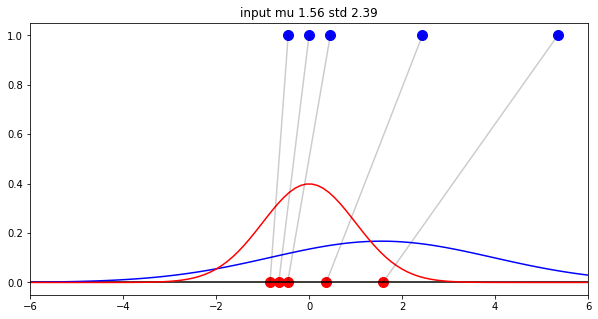

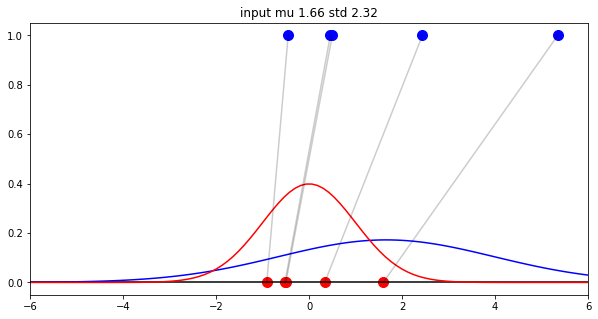

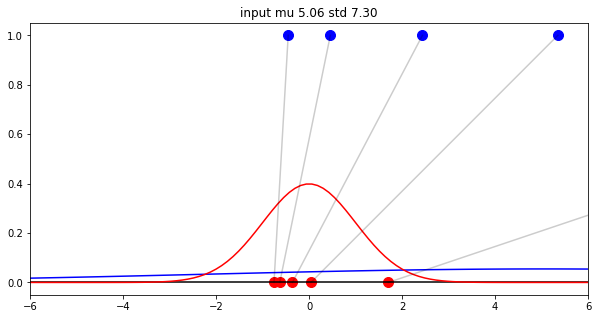

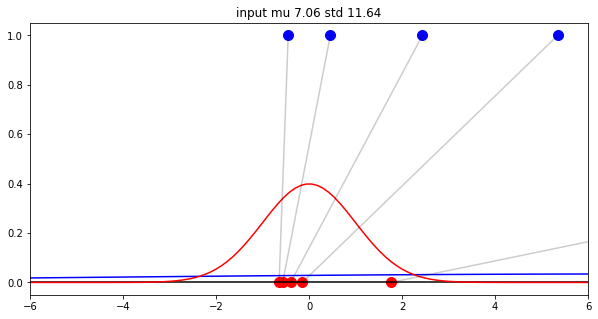

In [76]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


In [77]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [78]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
